In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def y(x):
    return 3 * x**2 - 4 * x + 5

In [3]:
y(3.0)

20.0

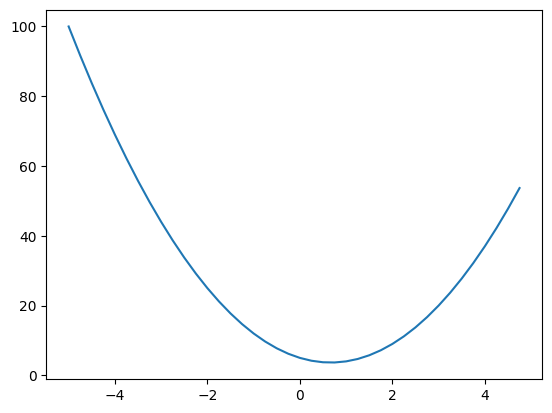

In [4]:
xs=np.arange(-5,5,0.25)
ys=y(xs)
plt.plot(xs,ys)

In [5]:
h=0.000000001
x=3.0
(y(x+h)-y(x))/h

14.000001158365194

In [6]:
class Value:
    def __init__(self,data,prev=(),op='',label=''):
        self.data=data
        self.prev=set(prev)
        self.op=op
        self.label=label
        self.grad=0.0
        self._backward= lambda : None
    def __repr__(self):
        out=f"Value(data ={self.data})"
        return out
    def __add__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        ans=Value(self.data+other.data,(self,other),'+')
        def backward():
            self.grad+=1*ans.grad
            other.grad+=1*ans.grad
        ans._backward=backward
        return ans
    def __mul__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        ans=Value(self.data*other.data,(self,other),'*')
        def backward():
            self.grad+=other.data*ans.grad
            other.grad+=self.data*ans.grad
        ans._backward=backward
        return ans
    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only supporting int/float powers for now"
        ans=Value(self.data**other,(self,),f'**{other}')
        def backward():
            self.grad+=other*(self.data**(other-1))*ans.grad
        ans._backward=backward
        return ans
    def __rmul__(self,other):
        return self*other
    def __sub__(self,other):
        return self+(-other)
    def tanh(self):
        ans= self.__class__(
            data=math.tanh(self.data),
            prev=(self,),
            op="tanh"
        )
        def backward():
            self.grad+=(1-ans.data**2)*ans.grad
        ans._backward=backward
        return ans
    def expo(self):
        x=self.data
        ans=Value(math.exp(x),(self,),'exp')
        def backward():
            self.grad+=ans.data*ans.grad
        ans._backward=backward
        return ans
    def __truediv__(self,other):
        return self*(other**(-1))

    def backward(self):
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()


In [233]:
a=Value(5,label='a')
b=Value(3,label='b')
d=a+b
d.label='d'
c=Value(5,label='c')
e=c*d
e.label='e'
e

Value(data =40)

In [8]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n.op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n.op, label=n.op)
            # and connect this node to it
            dot.edge(uid + n.op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)
    return dot

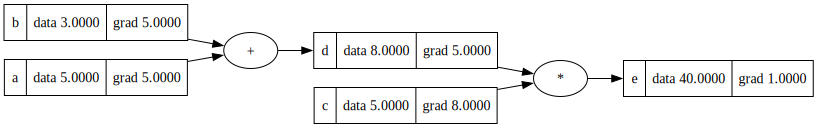

In [238]:
draw(e)

In [234]:
h=0.001
e.grad=((e.data+h)-e.data)/h
e.grad

0.9999999999976694

our aim is get de/dx---> where x is the varible in the backward
for multiplcation the derivative goes like this:
example:
a=b*x
-->da/dx=b
-->da/db=x
let x=n+m
de/dn=?
-->By applying chaine rule
da/dn=(da/dx)*(dx/dn)

for addition the derivative goes like this:
example:
x=n+m
dx/dn=1


Therefore:
da/dn=(da/dx)*(dx/dn)
     =b*1

In [235]:
c.grad=d.data
d.grad=c.data

In [236]:
b.grad=d.grad
a.grad=d.grad

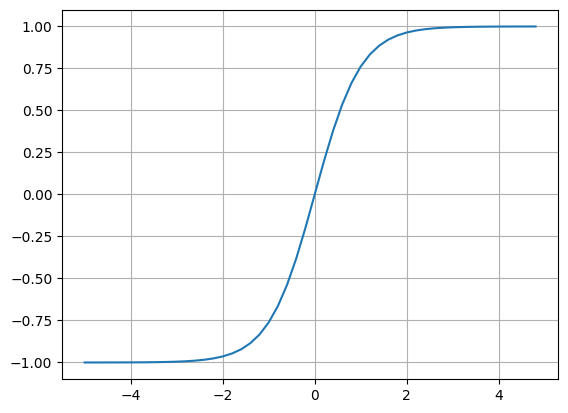

In [237]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

In [14]:
def activate_neuron():
    global x1,x2,w1,w2,b,x1w1,x2w2,sum_,n,o
    #inputs
    x1=Value(2.0,label="x1")
    x2=Value(0.0,label="x2")
    #weights
    w1=Value(-3.0,label="w1")
    w2=Value(1.0,label="w2")
    #bias
    b=Value(6.8813735870195432,label="b")
    # x1*w1 + x2*w2 + b
    x1w1=x1*w1
    x1w1.label="x1*w1"
    x2w2=x2*w2
    x2w2.label="x2*w2"
    sum_=x1w1+x2w2
    sum_.label="x1*w1 + x2*w2"
    n=sum_+b
    n.label="n"
    o=n.tanh()
    o.label="o"
activate_neuron()

In [118]:
o.grad=1.0

In [119]:
n.grad=1-o.data**2
b.grad=n.grad
sum_.grad=n.grad
x2w2.grad=x1w1.grad=sum_.grad
w1.grad=x1.data*x1w1.grad
x1.grad=w1.data*x1w1.grad
x2.grad=w2.data*x2w2.grad
w2.grad=x2.data*x2w2.grad

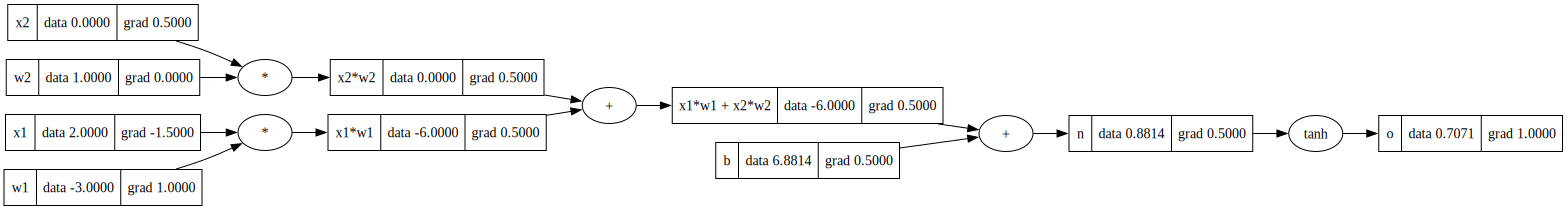

In [120]:
draw(o)

In [72]:
o._backward()

In [106]:
n._backward()

In [74]:
sum_._backward()

In [75]:
x1w1._backward()
x2w2._backward()

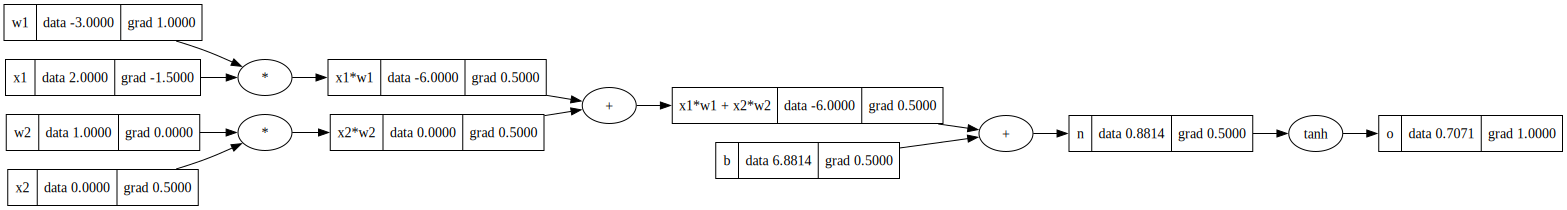

In [15]:
o.backward()
draw(o)

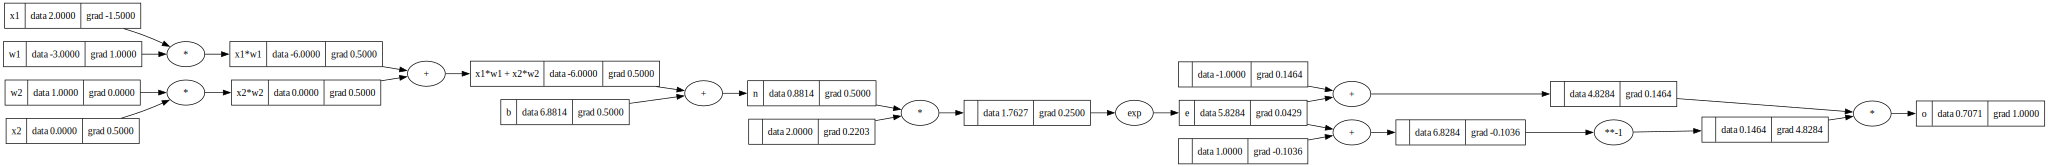

In [16]:
global x1,x2,w1,w2,b,x1w1,x2w2,sum_,n,o
#inputs
x1=Value(2.0,label="x1")
x2=Value(0.0,label="x2")
#weights
w1=Value(-3.0,label="w1")
w2=Value(1.0,label="w2")
#bias
b=Value(6.8813735870195432,label="b")
# x1*w1 + x2*w2 + b
x1w1=x1*w1
x1w1.label="x1*w1"
x2w2=x2*w2
x2w2.label="x2*w2"
sum_=x1w1+x2w2
sum_.label="x1*w1 + x2*w2"
n=sum_+b
n.label="n"

e=(2*n).expo()
e.label="e"

o=(e-1)/(e+1)
o.label="o"

o.backward()
draw(o)

In [17]:
import torch
x1 = torch.tensor([2.0]).double().requires_grad_(True)
x2 = torch.tensor([0.0]).double().requires_grad_(True)
w1 = torch.tensor([-3.0]).double().requires_grad_(True)
w2 = torch.tensor([1.0]).double().requires_grad_(True)
b = torch.tensor([6.8813735870195432]).double().requires_grad_(True)
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [18]:
torch.Tensor([2.0])

tensor([2.])

In [19]:
print(type(torch.Tensor([2.0])))
print(torch.Tensor([2.0]).dtype)
print(o)
print(o.data)
print(x2.grad)

<class 'torch.Tensor'>
torch.float32
tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
tensor([0.7071], dtype=torch.float64)
tensor([0.5000], dtype=torch.float64)


In [20]:
torch.Tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

'''python
# this is when the neuron is called
x = [2.0, 3.0]
nin = len(x)
n = Neuron(nin)
n(x)

# this is when the layer is called
x = [2.0, 3.0]
nin = len(x)
nout = 3
l = Layer(nin, nout)
l(x)

# this is when the MLP is called
mlp = MLP(3, [4, 4, 1])
x = [2.0, 3.0, -1.0]
mlp_out = mlp(x)
mlp_out


In [67]:
import random
class Neuron:
    def __init__(self,nin):#nin->number of input
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]#w->weights
        self.b=Value(random.uniform(-1,1))#b->bias
    def __call__(self,x):#x->are the inputs used here with random w
        # w * x + b
        act=sum((w*x for w,x in zip(self.w,x)),self.b)#bias is the starting the sum
        ans=act.tanh()
        return ans
    def parameters(self):
        return self.w+[self.b]

#to form the particular layer we will take set of neurons
class Layer:
    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
#Multi layer perception->it has the set of layers..
class MLP:
    def __init__(self,nin,nouts):#nouts says how much neurons each layers should have
        sz=[nin]+nouts
        self.layers=[Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for l in self.layers:
            x=l(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    #parameters are ments to nudge it a bit to get the expected outcome
x=[2,3,-1]
nin=len(x)
mlp=MLP(nin,[4,4,1])
mlp_out=mlp(x)
mlp_out
        
        

Value(data =-0.6338772510442359)

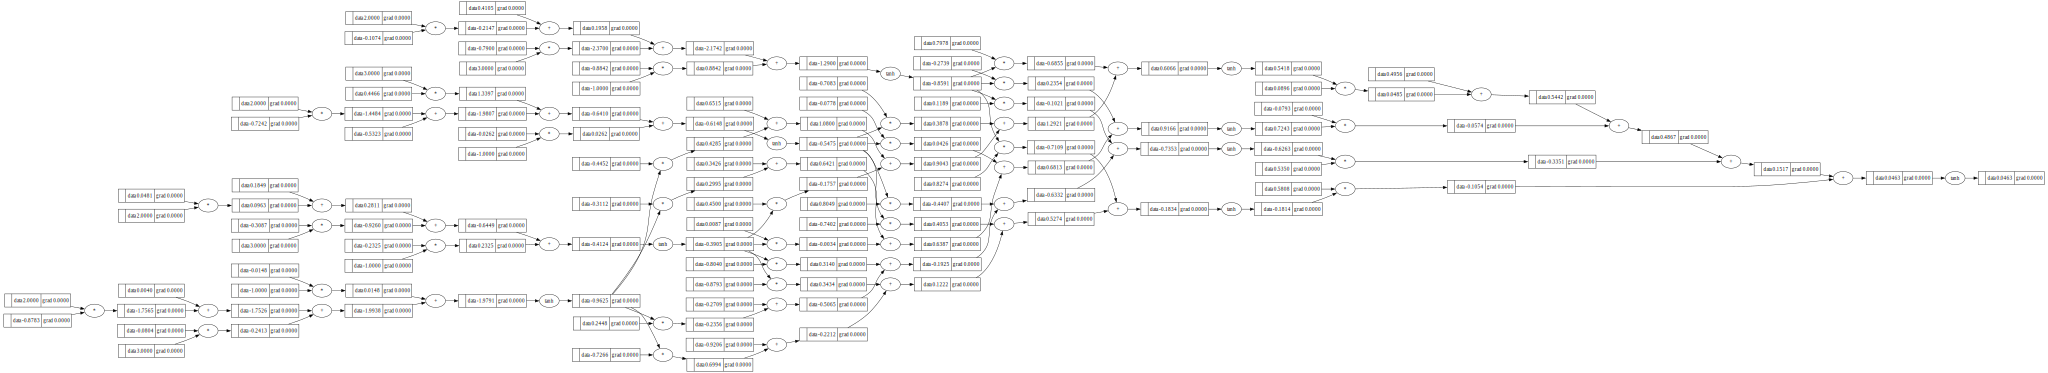

In [22]:
draw(mlp_out)

In [114]:
xs=[
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys=[1,-1,-1,1]# desired targets

In [115]:
def forward_pass_mlp(mlp):
    return [mlp(x) for x in xs]
ypreds=forward_pass_mlp(mlp)
ypreds

[Value(data =0.13966712067061215),
 Value(data =0.2159623617905405),
 Value(data =-0.2985942787521988),
 Value(data =0.4279156135018883)]

In [212]:
def calc_loss(ypreds, ys):
    return sum(
        ((ypred - y)**2 for ypred, y in zip(ypreds, ys)),
        Value(0.0)
    )
ypreds=forward_pass_mlp(mlp)
loss=calc_loss(ypreds,ys)
loss

Value(data =0.0022583269682903842)

In [213]:
for p in mlp.parameters():
    p.grad = 0.0

In [214]:
loss.backward()

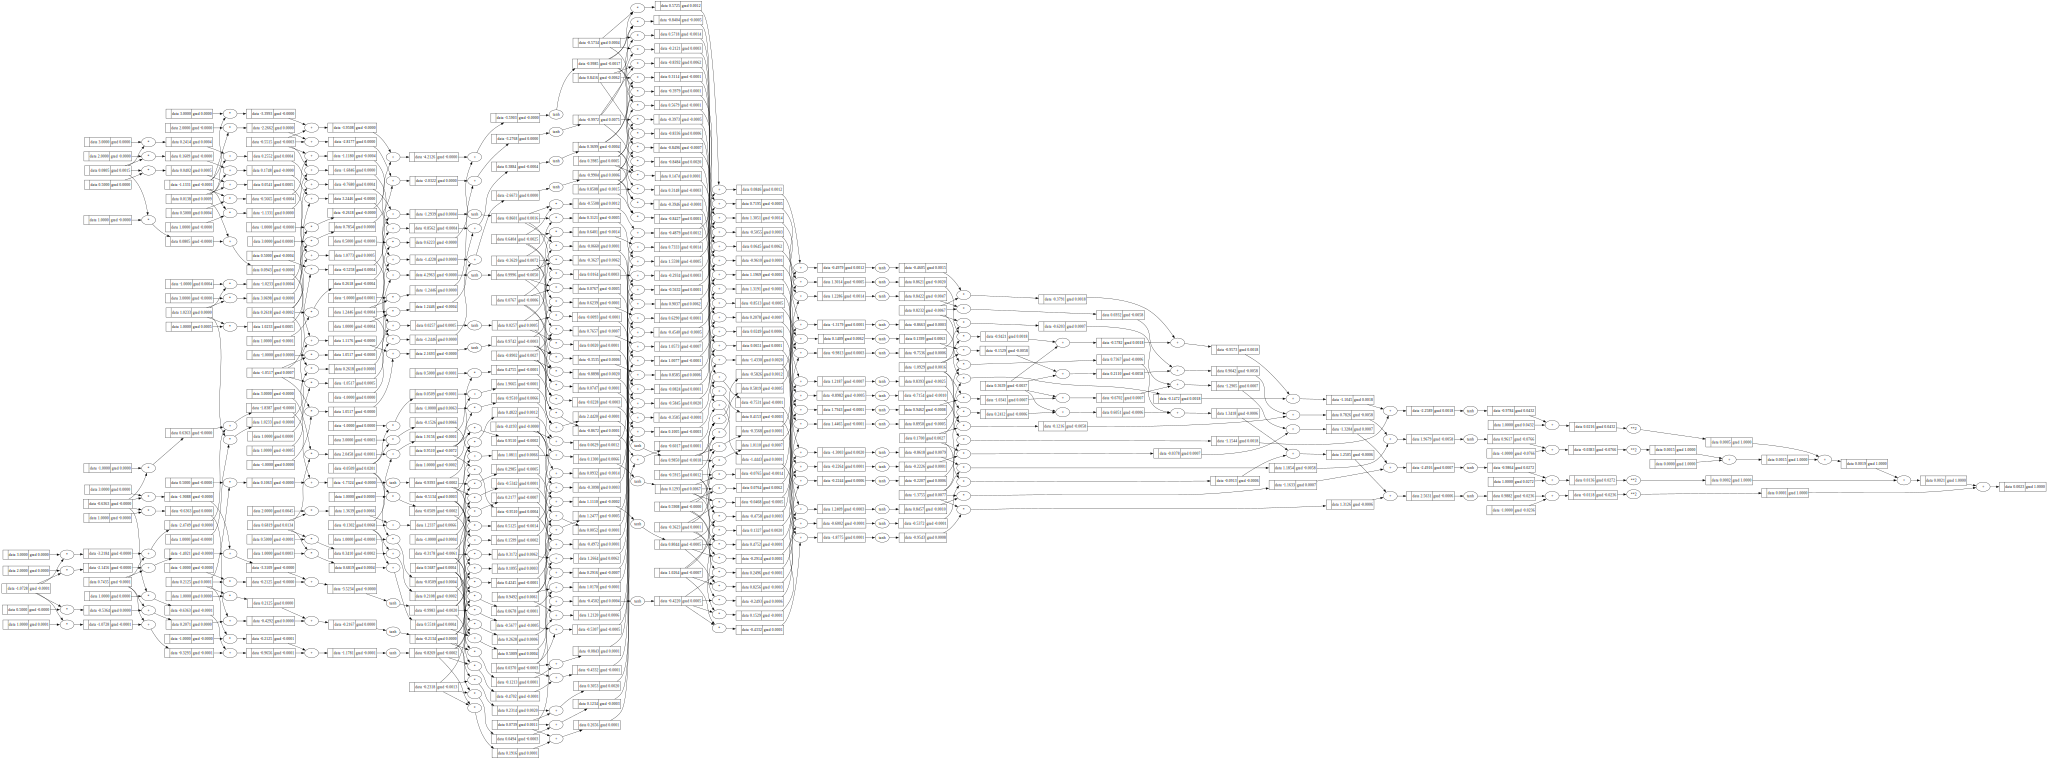

In [215]:
draw(loss)

In [216]:
mlp.parameters()

[Value(data =-1.072809740754712),
 Value(data =-0.6362645464149538),
 Value(data =0.2125047850677078),
 Value(data =0.7434806657342022),
 Value(data =0.08047220349045581),
 Value(data =1.0232766865486889),
 Value(data =-1.05167052213697),
 Value(data =0.01383123604817792),
 Value(data =-1.1330997644175649),
 Value(data =0.26180865133831344),
 Value(data =1.2445682819213888),
 Value(data =-0.5514680458028761),
 Value(data =0.6819301769668024),
 Value(data =-0.05087627217090406),
 Value(data =0.9510421624810728),
 Value(data =-0.13016766144730813),
 Value(data =-0.317791979526901),
 Value(data =-0.36285282584443435),
 Value(data =0.8416365309630125),
 Value(data =0.5907752925781014),
 Value(data =0.9492049069355015),
 Value(data =-0.5133898331530595),
 Value(data =0.6403595623641648),
 Value(data =-0.5733852377574266),
 Value(data =-0.5914699485562311),
 Value(data =-0.41932129740444624),
 Value(data =0.5686655177806713),
 Value(data =0.0767183602032174),
 Value(data =0.3984683165361439)

In [217]:
mlp.layers[0].neurons[0].w[0].grad

-0.00014297952058671607

In [218]:
mlp_params=mlp.parameters()
print(mlp_params)
print(len(mlp_params))

[Value(data =-1.072809740754712), Value(data =-0.6362645464149538), Value(data =0.2125047850677078), Value(data =0.7434806657342022), Value(data =0.08047220349045581), Value(data =1.0232766865486889), Value(data =-1.05167052213697), Value(data =0.01383123604817792), Value(data =-1.1330997644175649), Value(data =0.26180865133831344), Value(data =1.2445682819213888), Value(data =-0.5514680458028761), Value(data =0.6819301769668024), Value(data =-0.05087627217090406), Value(data =0.9510421624810728), Value(data =-0.13016766144730813), Value(data =-0.317791979526901), Value(data =-0.36285282584443435), Value(data =0.8416365309630125), Value(data =0.5907752925781014), Value(data =0.9492049069355015), Value(data =-0.5133898331530595), Value(data =0.6403595623641648), Value(data =-0.5733852377574266), Value(data =-0.5914699485562311), Value(data =-0.41932129740444624), Value(data =0.5686655177806713), Value(data =0.0767183602032174), Value(data =0.3984683165361439), Value(data =-0.36227591298

In [219]:
mlp.layers[0].neurons[0].w[0].data

-1.072809740754712

after the change of the loss by slight nudge the value of mlp

In [220]:
for p in mlp.parameters():
    p.data += (-0.01)*p.grad

In [221]:
mlp.layers[0].neurons[0].w[0].data

-1.0728083109595061

In [222]:
mlp.layers[0].neurons[0].w[0].grad

-0.00014297952058671607

In [223]:
ypreds

[Value(data =0.9616913886055034),
 Value(data =-0.9784109980373563),
 Value(data =-0.9863893193319792),
 Value(data =0.9881914595598795)]

## Rewring the above code of gradient descent


In [226]:
xs=[
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys=[1,-1,-1,1]# desired targets

In [227]:
for k in range(20):
    # forward pass
    ypreds=forward_pass_mlp(mlp)
    #Calculating loss
    loss=calc_loss(ypreds,ys)
    #zero gradients (so they don't accumulate)
    for p in mlp.parameters():
        p.grad = 0.0
    # backward pass
    loss.backward()
    #update
    for p in mlp.parameters():
        p.data += (-0.05)*p.grad
    print(k,loss.data)
    

0 0.0022483584759026443
1 0.0021997577798103206
2 0.0021540985821463746
3 0.002111112220868507
4 0.002070561807281531
5 0.0020322376700063305
6 0.0019959535602931166
7 0.0019615434743670284
8 0.0019288589789179039
9 0.0018977669492415544
10 0.0018681476476658846
11 0.0018398930840376696
12 0.0018129056111541942
13 0.0017870967168044395
14 0.001762385981066856
15 0.0017387001730944439
16 0.0017159724661080318
17 0.0016941417529472446
18 0.0016731520474763853
19 0.0016529519595476706


# After training the prediction values should be significantly closer to target values:

In [228]:
print([y.data for y in ypreds])
print(ys)

[0.9698845914167792, -0.9786748521583558, -0.9865293332643339, 0.9895217686300608]
[1, -1, -1, 1]


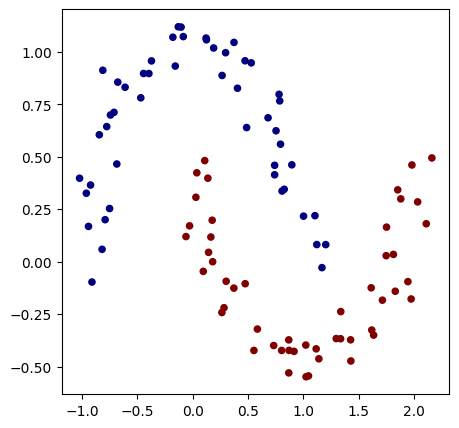

In [229]:
from sklearn.datasets import make_moons


np.random.seed(1337)
random.seed(1337)

# make up a dataset
X_moons, y_moons = make_moons(n_samples=100, noise=0.1)

y_moons = y_moons * 2 - 1  # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, s=20, cmap="jet");

In [240]:
from micrograd.nn import MLP

# initialize a model
model = MLP(2, [16, 16, 1])  # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [241]:
from micrograd.engine import Value


# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X_moons, y_moons
    else:
        ri = np.random.permutation(X_moons.shape[0])[:batch_size]
        Xb, yb = X_moons[ri], y_moons[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi * scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p * p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)


total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.8958441028683222, grad=0) 0.5


In [242]:
# optimization
for k in range(100):

    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9 * k / 100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.8958441028683222, accuracy 50.0%
step 1 loss 1.7235905336972022, accuracy 81.0%
step 2 loss 0.7429006313851131, accuracy 77.0%
step 3 loss 0.7705641260584201, accuracy 82.0%
step 4 loss 0.3692793385976538, accuracy 84.0%
step 5 loss 0.31354548191852194, accuracy 86.0%
step 6 loss 0.2814234349772435, accuracy 89.0%
step 7 loss 0.26888733313983904, accuracy 91.0%
step 8 loss 0.2567147286057417, accuracy 91.0%
step 9 loss 0.27048625516379227, accuracy 91.0%
step 10 loss 0.24507023853658041, accuracy 91.0%
step 11 loss 0.25099055297915035, accuracy 92.0%
step 12 loss 0.2156095185192295, accuracy 91.0%
step 13 loss 0.23090378446402726, accuracy 93.0%
step 14 loss 0.2015215122789945, accuracy 92.0%
step 15 loss 0.2257450627928222, accuracy 93.0%
step 16 loss 0.19447987596204114, accuracy 92.0%
step 17 loss 0.21089496199246355, accuracy 93.0%
step 18 loss 0.15983077356303602, accuracy 94.0%
step 19 loss 0.1845374874688391, accuracy 93.0%
step 20 loss 0.1897752285608764, accuracy

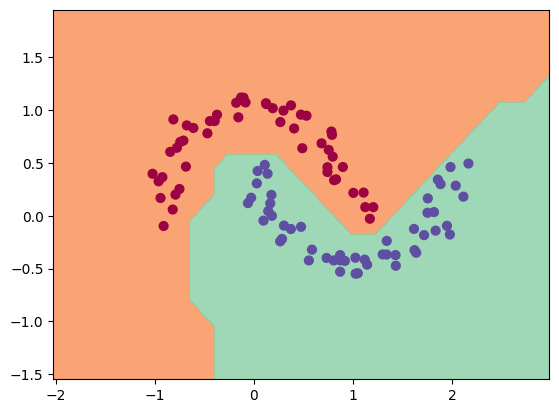

In [244]:
# visualize decision boundary

h = 0.25
x_min, x_max = X_moons[:, 0].min() - 1, X_moons[:, 0].max() + 1
y_min, y_max = X_moons[:, 1].min() - 1, X_moons[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max());